In [1]:
import torch
import torch.nn as nn
import numpy as np;
import matplotlib.pyplot as plt;

import numpy as np;
import matplotlib.pyplot as plt;
import tensorflow as tf;
import keras
from keras import layers;
from scipy import linalg;
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [3]:
def generate_signal(N):
    # центр, ширина и высота первого треугольника
    width1 = np.random.uniform(0.1, 0.2)
    center1 = np.random.uniform(width1, 0.5 - width1)
    height1 = np.random.uniform(-2, 2)
    # центра, ширина и высота второго треугольника
    width2 = np.random.uniform(0.1, 0.2)
    center2 = np.random.uniform(0.5 + width2, 0.5 - width2)
    height2 = np.random.uniform(-2, 2)
    signal = np.zeros(N)
    dt = 1.0/(N - 1)
    for i in range(N):
        t = i*dt
        if t > center2 + width2:
            signal[i] = 0.0
        elif t > center2:
            signal[i] = height2*(center2 + width2 - t)/width2
        elif t > center2 - width2:
            signal[i] = height2*(t - center2 + width2)/width2
        elif t > center1 + width1:
            signal[i] = 0.0
        elif t > center1:
            signal[i] = height1*(center1 + width1 - t)/width1
        elif t > center1 - width1:
            signal[i] = height1*(t - center1 + width1)/width1
        elif t > 0:
            signal[i] = 0.0
            
    return signal

In [4]:
#test signal = f0
def test_signal(x):
    if x > 0.7:
        return 0.0
    elif x > 0.6:
        return (0.7 - x)/0.1
    elif x > 0.5:
        return (x - 0.5)/0.1  
    elif x > 0.4:
        return (0.5 - x)/0.1  
    elif x > 0.3:
        return (x - 0.3)/0.1
    else:
        return 0.0

In [5]:
#генерация матрицы А, она характеризует прибор измерения (размазывание)
#in out типа до и после измерения
#модель определяется матрицей А которую выбираем, выбрали ту, у которой ненулевые диагон элементы
def generate_smoothing_matrix(size_in, size_out, half_width):
    m = np.zeros([size_out, size_in])
    width = 2.0*half_width
    value = 1.0 / width
    # value = 1.0
    for i in range(size_out):
        m[i, i] = value
        for j in range(0, half_width):
            index_right = i + j + 1
            index_left = i - j - 1
            if index_right < size_out:
                m[i, index_right] = value
            if index_left >= 0:
                m[i, index_left] = value
    return m

In [6]:
#для генерации мю или ню в зависимости от того какой оператор подадим
#!!!если sqrt F то мю, если sqrt sigma, то ню
#генерация случайного вектора с нулевым средним и ковариационным оператором
#(ковариационный оператор определяет ковариацию (взаимосвязь) между координатами)
def generate_correlated_vector(sqrt_covariance_operator):
    return sqrt_covariance_operator@np.random.normal(0, 1, np.size(sqrt_covariance_operator, 0))
#np.random.normal - нескоррелированный вектор с нормальным распределением
#потом домнажаем его на корень из ковариационного оператора

In [7]:
# generate test signal
#f0
N = 101  #число отрезков (типа дискретизация непрерывного сигнала)
halfWidth = 10
sigma = 1.0 #дисперсия 
A = generate_smoothing_matrix(N, N, halfWidth)
t = np.arange(0, 1.0 + 1.e-10, 1.0/(N - 1)) #в каких точках задана дискретизация
f0 = np.zeros(N)

for i in range(N):
    f0[i] = test_signal(t[i])

In [8]:
#ksi (само измерение)
# b0 = np.arange(1, 12)
# b = np.concatenate((b0, np.zeros(N - np.shape(b0)[0])))
#генерируем корень из матрицы F
# sqrt_F = 0.005*linalg.toeplitz(b)
sqrt_F = 0.1*np.eye(N)
F = sqrt_F.T@sqrt_F #@-матричное умножение

#!!!аналогично для сигма, которая отвечает за шум ню (ковариационный оператор ню (дисперсия вектора))
#диагональная матрица с 0.1 на диагонали (0.1=дисперсия чтобы шум не был слишком большим)
sqrt_Sigma = 0.1*np.eye(N)
Sigma = sqrt_Sigma.T@sqrt_Sigma

#смоделировали измерения, на котором будем тестировать нейросеть
f = f0 + generate_correlated_vector(sqrt_F)
nu = generate_correlated_vector(sqrt_Sigma)
smoothed_f = A@f
ksi = A@f + nu

#линейная оценка (для дальнейшего сравнения успешности нейросети, так как эти формулы знаем)
Sigma_inversed = np.linalg.inv(Sigma)
T = A.T@Sigma_inversed@A
v = A.T@Sigma_inversed@ksi
T_aprior = np.linalg.inv(F)
v_aprior = T_aprior@f0 # here is not f!!!
#выражение значения f через известные f0,F,A,sigma,ksi
lin_est_f = np.linalg.inv(T + T_aprior)@(v + v_aprior)

In [9]:
n_train = 10000

f_train = np.zeros([n_train, N])
ksi_train = np.zeros([n_train, N])

for i in range(n_train):
    signal = generate_signal(N)
    temp_f = signal + generate_correlated_vector(sqrt_F)
    f_train[i, :] = temp_f
    ksi_train[i, :] = A@temp_f + generate_correlated_vector(sqrt_Sigma)


print(f_train.shape)


(10000, 101)


In [33]:
model = keras.Sequential([
    # best!
#     keras.layers.Dense(4*N, activation=keras.activations.tanh), #sigmoid
#     keras.layers.Reshape((4*N, 1), input_shape=(4*N,)),
#     keras.layers.convolutional.Conv1D(50, 9, activation='tanh',input_shape=(4*N, 1)),
#     keras.layers.normalization.BatchNormalization(),
#     keras.layers.Reshape((50*(4*N-8),), input_shape=(50*(4*N-8),1)),
#     keras.layers.Dense(N, activation=keras.activations.sigmoid) #sigmoid
    
    keras.layers.Dense(4*N, activation=keras.activations.tanh), #sigmoid
    keras.layers.Reshape((4*N, 1), input_shape=(4*N,)),
    keras.layers.convolutional.Conv1D(100, 15, activation='tanh',input_shape=(4*N, 1)),
    keras.layers.normalization.BatchNormalization(),
    keras.layers.Reshape((100*(4*N-14),), input_shape=(50*(4*N-14),1)),
    keras.layers.Dense(N, activation=keras.activations.sigmoid) #sigmoid
    
#     keras.layers.Reshape((N, 1), input_shape=(N,)),
#     keras.layers.convolutional.Conv1D(150, 11, activation='tanh',input_shape=(N, 1)),
#     keras.layers.Reshape((1, 150*(N-10)), input_shape=(N-10, 150)),
#     keras.layers.Dense(N+10, activation='relu'),
#     keras.layers.normalization.BatchNormalization(),
#     keras.layers.Permute((2, 1)),
#     keras.layers.convolutional.Conv1D(1, 11, activation='relu'),
#     keras.layers.Reshape((N,), input_shape=(N, 1)),
    
#     keras.layers.Reshape((N-10,), input_shape=(N-10, 1)),
#     keras.layers.Dense(N, activation=keras.activations.sigmoid), #sigmoid
#     keras.layers.Permute((2, 1), input_shape=(93, N)),
#     keras.layers.Dense(N, activation=keras.activations.sigmoid), #sigmoid
#     keras.layers.Reshape((N,), input_shape=(N, 1)),
])
# print(model.summary())

In [34]:
print(f_train.shape)
f_train.shape

(10000, 101)


(10000, 101)

In [35]:
X = ksi_train
y = f_train
print(X.shape)
print(y.shape)
model.compile(loss="mse", optimizer="adam")
model.fit(X, y,
          batch_size = 64,
          epochs=100,
          validation_split=0.1,
#           shuffle = False
#           callbacks=[plot],
         )



(10000, 101)
(10000, 101)
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 19s 2ms/step - loss: 0.2590 - val_loss: 0.1978
Epoch 2/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1418 - val_loss: 0.2443
Epoch 3/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1394 - val_loss: 0.2242
Epoch 4/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1392 - val_loss: 0.2165
Epoch 5/100
9000/9000 [==============================] - 19s 2ms/step - loss: 0.1391 - val_loss: 0.2286
Epoch 6/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1390 - val_loss: 0.2348
Epoch 7/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1390 - val_loss: 0.2404
Epoch 8/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1390 - val_loss: 0.2451
Epoch 9/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1389 - val_los

9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1412
Epoch 79/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1462
Epoch 80/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1420
Epoch 81/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1408
Epoch 82/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1393
Epoch 83/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1396
Epoch 84/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1395
Epoch 85/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1388
Epoch 86/100
9000/9000 [==============================] - 18s 2ms/step - loss: 0.1378 - val_loss: 0.1381
Epoch 87/100
9000/9000 [==============================] - 18s 2ms/st

In [38]:
X_test = ksi.reshape([1, N])
f_ANN = model.predict_on_batch(X_test).reshape(N,)
f_ANN.shape
mse = np.sqrt(((f_ANN - f)**2).mean())
print(mse)
mse_r = np.sqrt(((lin_est_f - f)**2).mean())
print(mse_r)
# f.shape

0.12381726340296895
0.10002257581306873


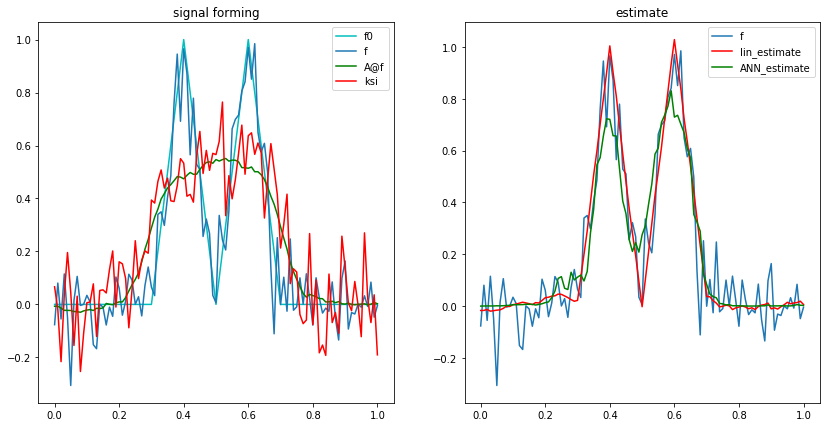

In [37]:
plt.subplot(1, 2, 1)
plt.plot(t, f0, 'c')
plt.plot(t, f)
plt.plot(t, smoothed_f, 'g')
plt.plot(t, ksi, 'r')
plt.title('signal forming')
plt.legend(['f0', 'f', 'A@f', 'ksi'])
plt.subplot(1, 2, 2)
plt.plot(t, f)
plt.plot(t, lin_est_f.transpose(), 'r')
plt.plot(t, f_ANN.reshape(101,), 'g')
plt.title('estimate')
plt.legend(['f', 'lin_estimate', 'ANN_estimate'])
plt.rcParams["figure.figsize"] = (14,7)
plt.show()